# How to Build Machine Learning Pipelines And Track Experiments with DVC Inside VSCode
## Manage ML experiments like a pro


### Why track experiments?

Keeping track of machine learning experiments is like trying to keep FIVE dogs in a bathtub. Without help, at least FOUR of them are bound to slip out of your hands and ruin everything. 

A total disaster is what's going to happen if you don't have a proper experiment management system. First, you'll probably end up with a complete mess of code, with no idea which version of the model is the most recent or the best performing. You'll be constantly overwriting and losing important code, and it will be almost impossible to reproduce your results or track your progress.

On top of that, you'll have no way of keeping track of hyperparameters, metrics, or any other important details of your experiments (unless you want to write them down😱). You'll be flying blind.

But hey, at least you'll have a lot of fun trying to untangle the mess you've created! Nothing like wasting countless hours trying to figure out what went wrong, right?

In all seriousness, a proper experiment management system is crucial for any machine learning project. It allows you to track and compare your experiments, reproduce results, and make informed decisions about the direction of your project. Without it, you're just shooting in the dark and hoping for the best.

### What you will learn in this tutorial

### Project setup

Start by forking [the following GitHub repository](https://github.com/BexTuychiev/dvc-tutorial), cloning the `experiments` branch and opening the project with VSCode:

```
$ git clone --branch experiments https://github.com/YourUsername/dvc-tutorial.git dvc-tutorial
$ cd dvc-tutorial
$ code .
```

The cloned repository only contains a single `train.py` inside the `src` directory and the `requirements.txt` file. Install its contents inside a virtual environment, preferably `conda`:

```
$ conda create -n dvc-tutorial python==3.9 -y
$ conda activate dvc-tutorial
$ python -r requirements.txt
```

Now, you can initialize DVC and download the dataset:

```
$ dvc init
$ dvc get REMOTE_LINK # To be added later
```

The `get` command will download a `data` directory, which you should track with DVC and:

```
$ dvc add data
```

Afterwards, our project tree should resemble the following structure:

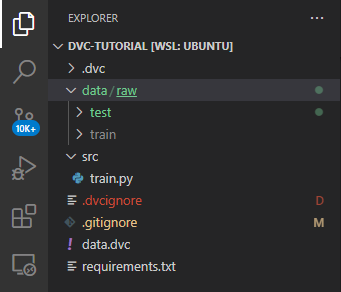

The `train` and `test` folders contain images with varying sizes from the [German Traffic Signs Recognition Benchmark dataset](https://www.kaggle.com/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign). There are 43 classes of traffic signs and over 40k images.

Let's commit the changes:

```
$ git add --all
$ git commit -m "Track the dataset with DVC"
```

You should also install the [DVC VSCode extension](https://marketplace.visualstudio.com/items?itemName=Iterative.dvc) from the marketplace as it is the main focus of our tutorial:

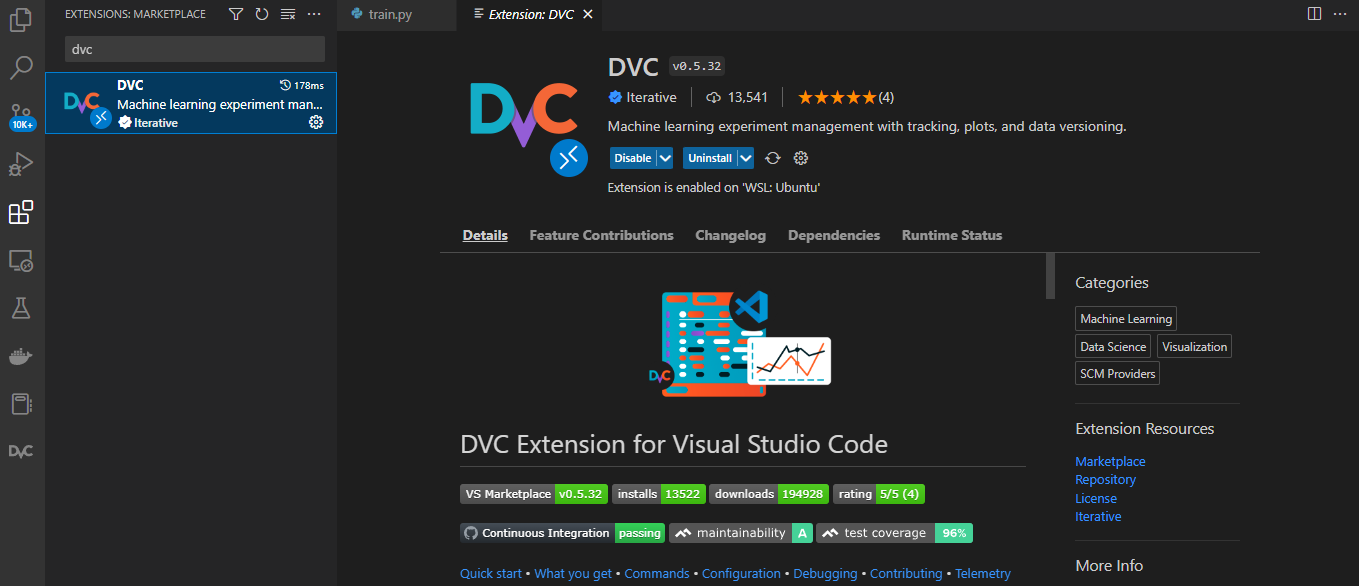

Once the extension is correctly set up, it should automatically detect DVC-enabled directories in your projects. If you see an empty circle on the bottom left (instead of a red cross inside), everything is working as expected:



> Windows users might have a problem the extension, mainly when it tries to detect DVC-enabled repositories. If you are unable to resolve the issues, I suggest installing the WSL2 Ubuntu distribution on your machine (like I did). You can read my step-by-step tutorial on the topic from Medium [here](https://medium.com/towards-data-science/how-to-create-perfect-machine-learning-development-environment-with-wsl2-on-windows-10-11-2c80f8ea1f31).

### Running experiments with DVCLive

In machine learning, a single run of a training script (or a chain of scripts) is called an experiment. A typical training script trains a single model, and saves it to the disk. The script also reports the exact hyperparameters of the model and one or more metrics to quantify the model's performance.

> A hyperparameter is a user-defined "settings" of a model. For example, a popular Random Forest model has a `n_estimators` parameter that controls the number of trees built inside the ensemble.

Currently, our `src/train.py` does not perform any of the listed tasks. But we can add that functionality with a single line of code using the DVCLive library. 

```python
import ...
from dvclive.keras import DVCLiveCallback

# The rest of the script
...

# Line 87
callbacks = [
        ...,
        DVCLiveCallback(save_dvc_exp=True)
    ]
```

DVCLive is an auto-experiment tracking library that integrates seamlessly with `dvc` and the DVC VSCode extension. It is framework-specific, meaning it has separate tracking callbacks for many popular ML and DL frameworks:

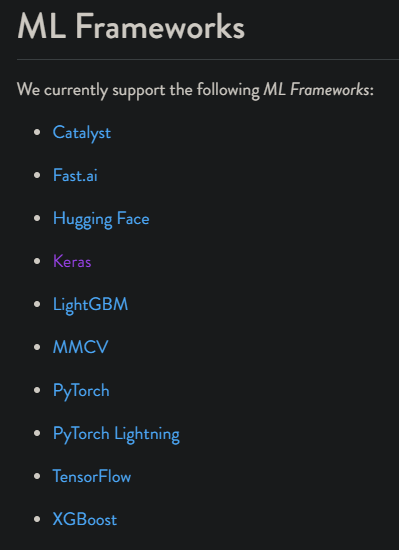

Currently, the training script fits a simple baseline CNN with only two layers.

```python
def get_model():
    """Define the model to be fit"""
    # Define a CNN model
    model = tf.keras.models.Sequential(
        [
            tf.keras.layers.Conv2D(
                filters=32,
                kernel_size=3,
                activation="relu",
                input_shape=(30, 30, 3),
            ),
            tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation="relu"),
            # tf.keras.layers.MaxPooling2D(2, 2),
            # tf.keras.layers.BatchNormalization(axis=-1),
            # tf.keras.layers.Conv2D(filters=128, kernel_size=3, activation="relu"),
            # tf.keras.layers.Conv2D(filters=256, kernel_size=3, activation="relu"),
            # tf.keras.layers.MaxPooling2D(2, 2),
            # tf.keras.layers.BatchNormalization(axis=-1),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(512, activation="relu"),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(43, activation="softmax"),
        ]
    )
```
> The rest of the layers are commented out for now.

The model is compiled with Adam optimizer (default learning rate) and three metrics: accuracy, precision and recall. The training loop will run for 10 epochs. 

We run the script after we save the changes made to `script.py`:

```
$ git commit -am "exp: Baseline"
$ python src/train.py
```

![](images/first_train_2.gif)

Once the run finishes, the DVC panel view will contain the experiment results:

![](images/first_train.gif)

Currently, the experiments table shows only a single experiment and four metrics for both training and validation sets. There is also a column for the number of epochs.

You've also seen the Plots tab, which appears once you select an experiment. By default, DVCLive shows the training progress as the number of epochs increase. In fact, these plots are updated automatically as an experiment runs. Here is how it looks like in fast-forward:

![](images/live_train.gif)

Along with the `models/model.keras` generated from the script, `DVCLive` produces a `dvclive` directory that contains the images you see in the GIF:

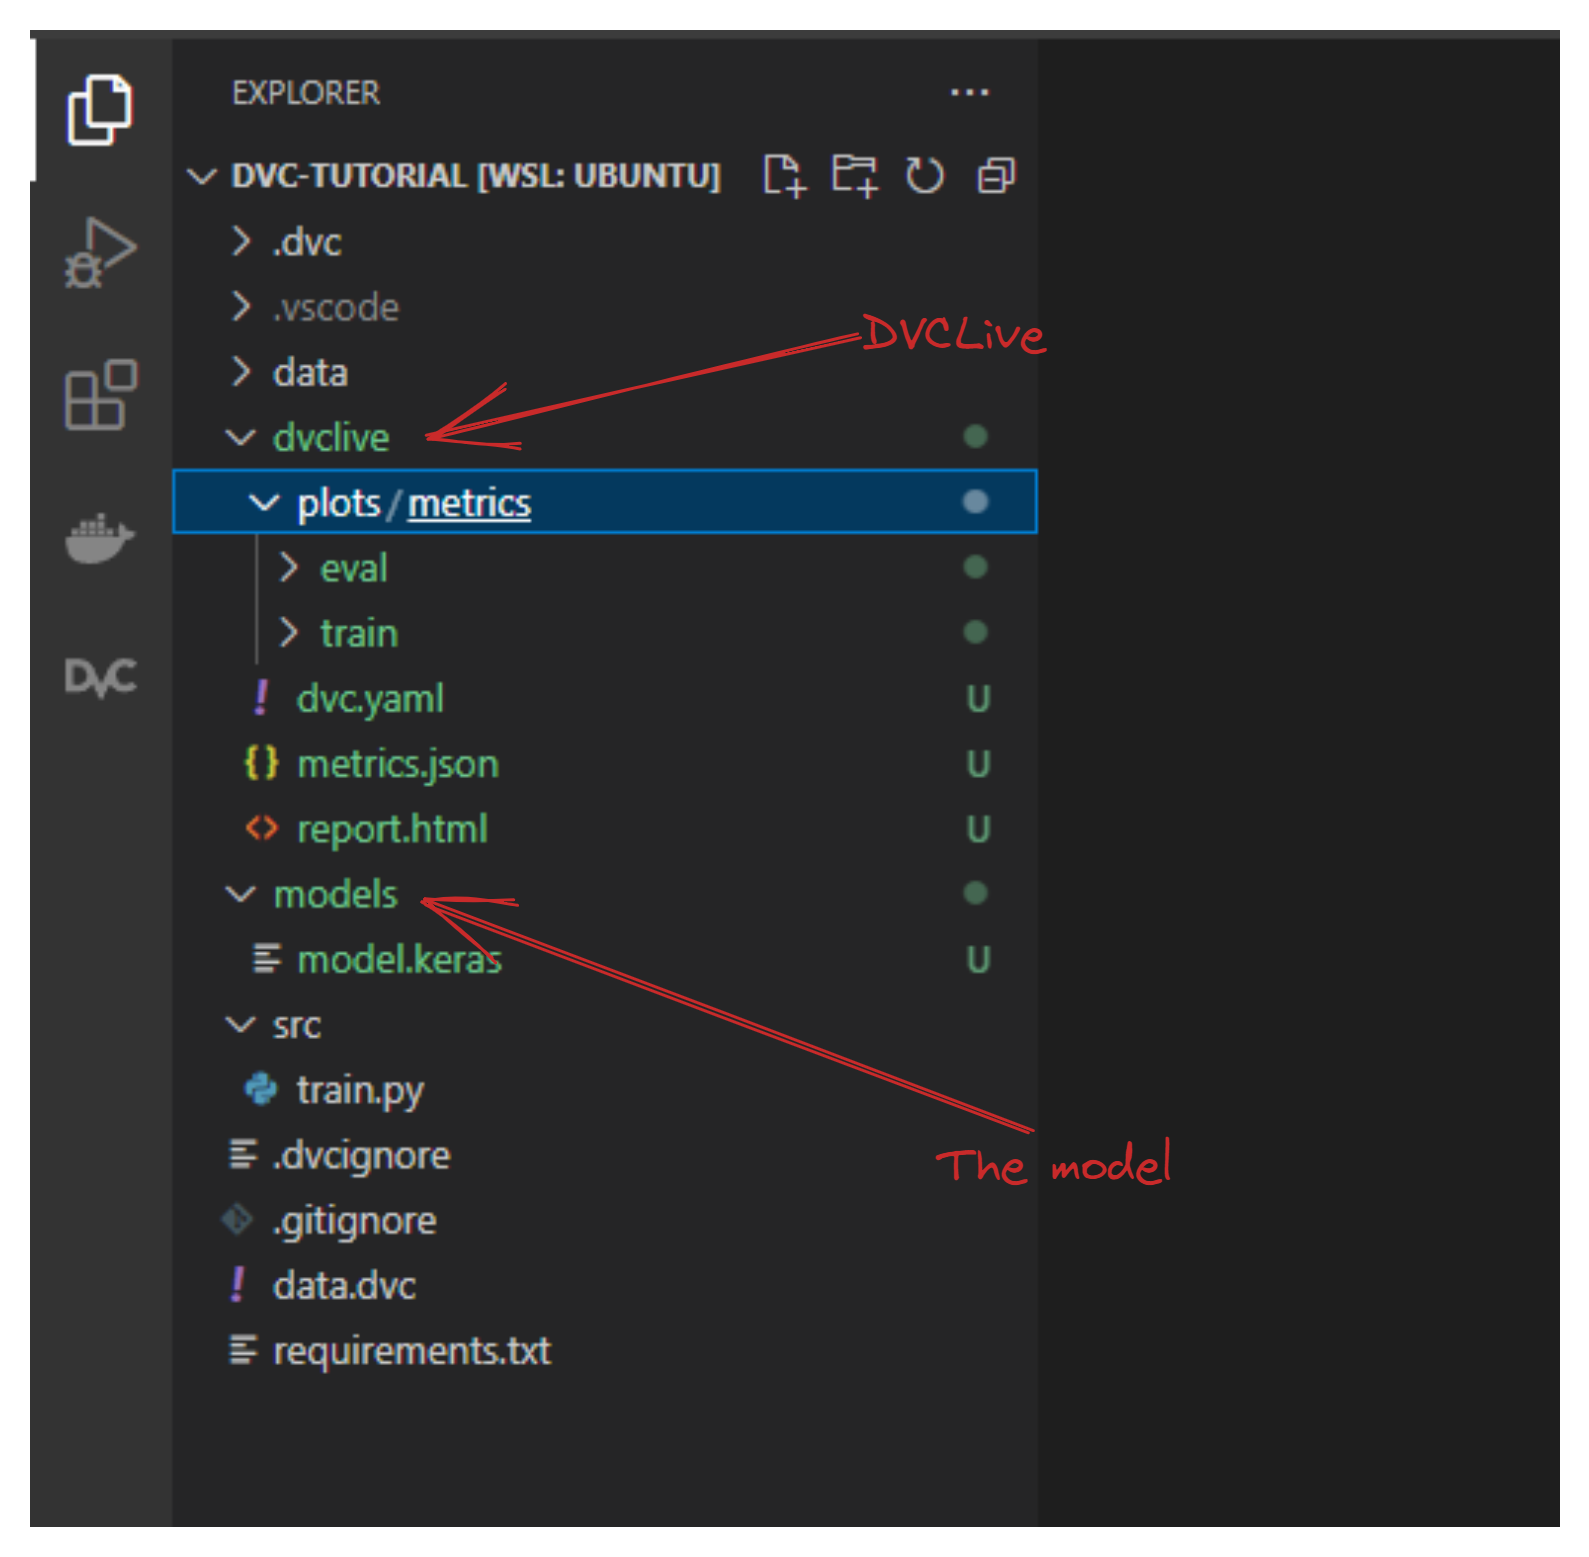

Since both directories contain large binary files and plots, they should be tracked with DVC:

```
$ dvc add dvclive models
$ git add --all
$ git commit -m "exp: Run the baseline experiment"
```

### Capturing more parameters

Currently, `DVCLive` only captures limited information about our experiments. We will capture more parameters by changing the `train.py` script to the code found in [this gist](https://gist.github.com/BexTuychiev/71d0d209f8f1710a8dc397eb2d9c33bb). I've pasted the code there to save some space. Now, let's quickly run through the main changes in the script.

First, we import the `Live` class from `dvclive` and initialize it with `save_dvc_exp=True` so that each run of `train.py` is recorded as an experiment

```python
from dvclive import Live

...

# Set up the logger
logger = Live(save_dvc_exp=True)
```


Using the logger, we can capture user-defined hyperparameters with the `log_params` method:

```python
# Set the parameters
params = {
    "image_width": 30,
    "image_height": 30,
    "batch_size": 32,
    "learning_rate": 0.001,
    "n_epochs": 10
}

logger.log_params(params)
```

> When the script runs, these hyperparameters will populate the experiments table. 

Now, the rest of the script extracts the hyperparameters only from the `params` dictionary. We've also changed how we pass the `DVCLive` callback in line 100. Instead of passing the callback with `save_dvc_exp=True`, we pass it with `live=logger`. The `live` parameter expects a DVCLive logger, which initialized at the beginning of the scripts.

Now, let's run a fresh experiment (the rest of the CNN layers are uncommented in the new script) after we save the changes and tag them:

```
$ git add --all
$ git commit -m "Update train.py to use a DVCLive logger"
$ git tag cnn-all-layers
$ python src/train.py
```

Now, when you open the experiments tab and scroll right, you will see the new parameters logged with the metrics:

![](images/more_params.gif)

Don't forget to capture the experiment to Git history:

```
$ dvc add models dvclive
$ git commit -am "exp: CNN All layers, 0.992 val accuracy"
```

### Better experimentation workflow

Even though `DVCLive` is taking a lot of "behind-the-scenes" stuff for us, our experimentation workflow is still a bit tedious. Every time we want to run a new experiment, we have to repeat the following steps:

1. Update the training script for hyperparameters or new model architecture.
2. Capture the changes with Git.
3. Run the experiment.
4. Capture the experiment with both `dvc` and Git.

Besides, our experiments table currently looks a bit unorganized:

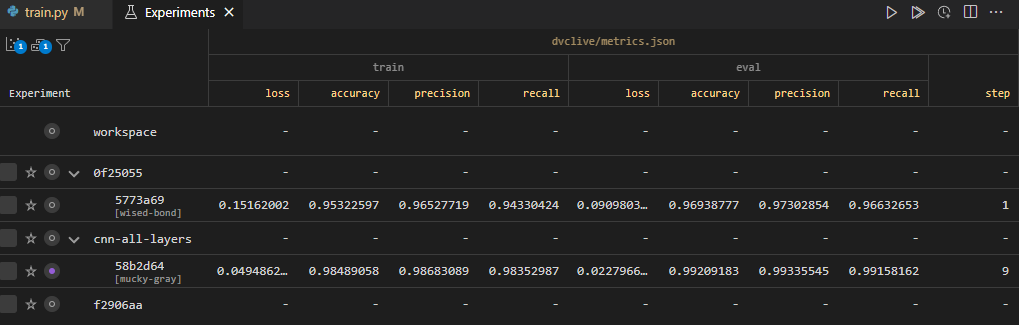

We have one experiment under the `cnn-all-layers` tag and one under `0f25055`, whatever that is. Let's solve all these issues.

### Managing experiments